In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
%%time
storage.samples.cache_all()
storage.samplesets.cache_all()
storage.pathmovechanges.cache_all()
#storage.steps.cache_all()

CPU times: user 33.2 s, sys: 5.7 s, total: 38.9 s
Wall time: 38.7 s


In [3]:
%%time
dummy = list(storage.steps)

CPU times: user 1min 30s, sys: 5.92 s, total: 1min 36s
Wall time: 1min 35s


In [4]:
print len(storage.steps)

25001


In [5]:
retis = storage.transitions.load(0)
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [6]:
%%time
print retis.conditional_transition_probability(storage, retis.ensembles[-1])

0.594736210552
CPU times: user 6.56 s, sys: 883 ms, total: 7.44 s
Wall time: 7.54 s


In [12]:
%%prun
print retis.total_crossing_probability(storage=storage)

In [13]:
%%prun
print retis.minus_move_flux(storage=storage)

0.00262540647156
 

In [14]:
%%prun
print retis.rate(storage)

7.14009509902e-06
 

In [6]:
%%time
retis.move_summary(storage)

pathreversal ran 24.9390024399% of the cycles with acceptance 4986/6235 (0.799679230152) 
shooting ran 49.0180392784% of the cycles with acceptance 9002/12255 (0.734557323541) 
minus ran 1.57993680253% of the cycles with acceptance 394/395 (0.99746835443) 
repex ran 24.4590216391% of the cycles with acceptance 2127/6115 (0.347833197056) 
CPU times: user 3.56 s, sys: 54.7 ms, total: 3.61 s
Wall time: 3.6 s


In [7]:
retis.move_summary(storage, 'shooting')

OneWayShootingMover I'face 2 ran 8.30366785329% of the cycles with acceptance 1566/2076 (0.754335260116) 
OneWayShootingMover I'face 5 ran 7.75568977241% of the cycles with acceptance 1234/1939 (0.636410520887) 
OneWayShootingMover I'face 0 ran 8.23567057318% of the cycles with acceptance 1740/2059 (0.845070422535) 
OneWayShootingMover I'face 4 ran 8.50765969361% of the cycles with acceptance 1395/2127 (0.655853314528) 
OneWayShootingMover I'face 1 ran 8.14767409304% of the cycles with acceptance 1643/2037 (0.806578301424) 
OneWayShootingMover I'face 3 ran 8.06767729291% of the cycles with acceptance 1424/2017 (0.705999008428) 


In [8]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [9]:
first40 = first_n(storage, 40, trajid=4)

In [10]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 293 ms, sys: 61.8 ms, total: 355 ms
Wall time: 345 ms


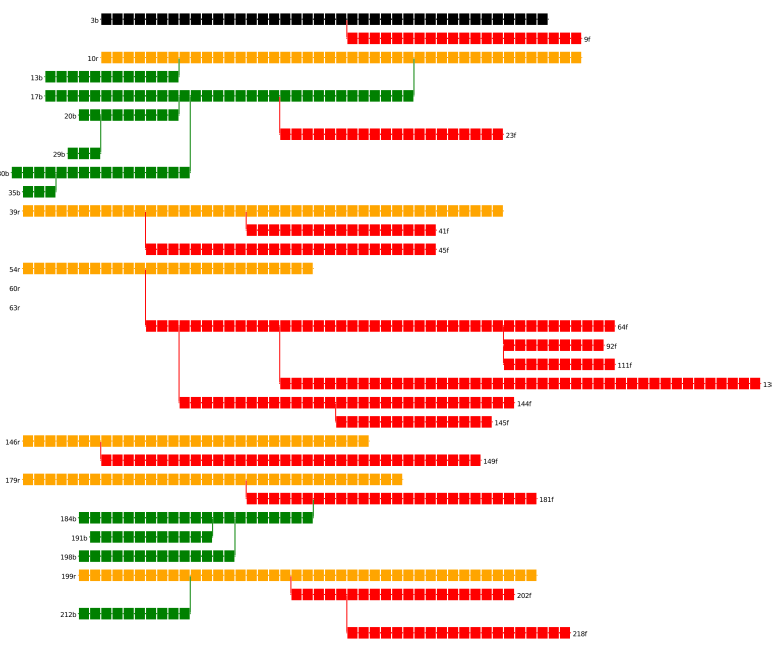

In [11]:
SVG(view.to_svg())

In [12]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 5 decorrelated trajectories.


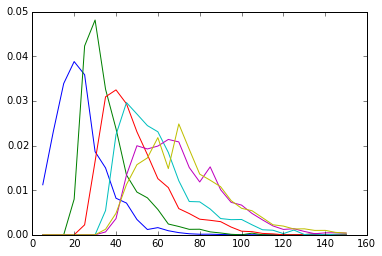

In [13]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

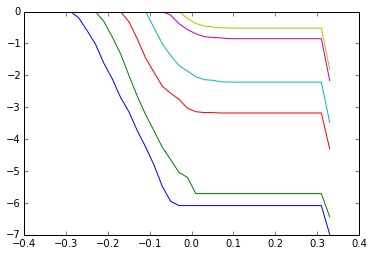

In [14]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

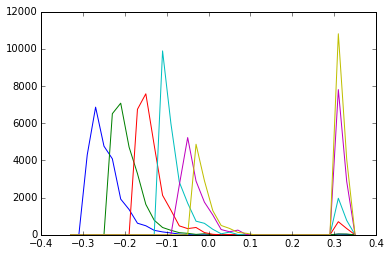

In [15]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

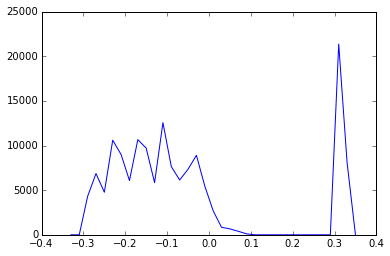

In [16]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling);

In [17]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

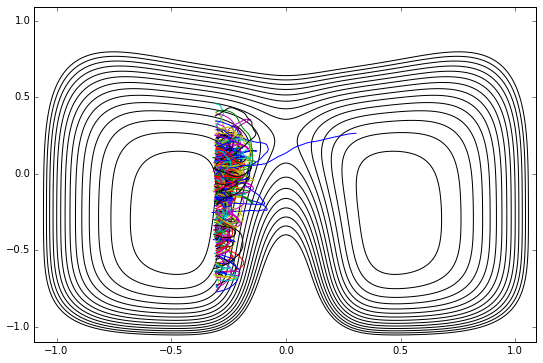

In [18]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

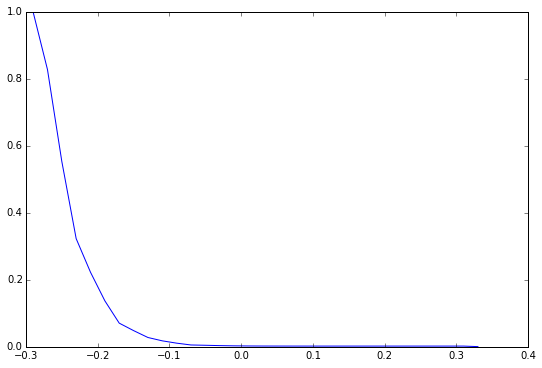

In [22]:
plt.plot(retis.tcp.keys(), retis.tcp.values());

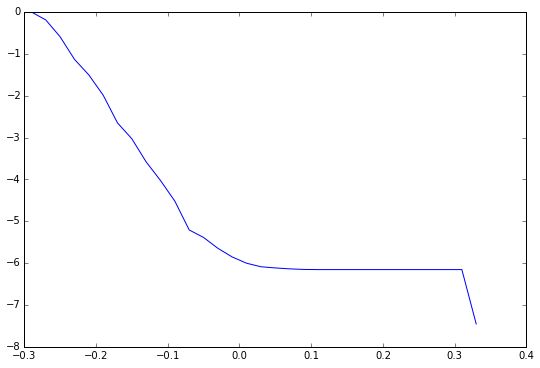

In [23]:
plt.plot(retis.tcp.keys(), np.log(retis.tcp.values()));

In [24]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 20.3 s, sys: 291 ms, total: 20.6 s
Wall time: 20.6 s


0.5947362105515779

In [25]:
retis.minus_move_flux(storage)

0.002625406471560318

In [26]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

0.00262540647156 0.00457280901614 0.594736210552


In [27]:
outer_ens = retis.ensembles[-1]

outer_cross_prob = retis.histograms['max_lambda'][outer_ens]
lambda_bin = -1
while (outer_cross_prob.reverse_cumulative()[lambda_bin+1] == 1.0):
    lambda_bin += 1

outer_cross_lambda = outer_cross_prob.bins[lambda_bin]

In [28]:
retis.rate(storage)

7.1400950990154911e-06

In [29]:
print retis._flux * retis.tcp(-0.05) * retis.ctp[retis.ensembles[-1]]

7.14009509902e-06
